In [18]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [19]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [20]:
x_train, x_val = train_test_split(train_data, test_size=0.2)

display(x_train.shape)
display(x_val.shape)

(961, 51)

(241, 51)

In [21]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        min_val = tf.reduce_min(inputs, axis=0)
        max_val = tf.reduce_max(inputs, axis=0)
        min_max_diff = max_val - min_val
        normalized_inputs = tf.where(
            min_max_diff != 0,
            (inputs - min_val) / (min_max_diff + 1e-8),
            tf.zeros_like(inputs),
        )
        return normalized_inputs
    
    def compute_output_shape(self, input_shape):
        return (None, input_shape[1])


class MSELoss(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs, targets):
        return tf.math.reduce_mean(tf.math.pow(inputs - targets, 2), axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],)

In [22]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, latent_dim, l2_lambda, name="encoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dense_0 = tf.keras.layers.Dense(intermediate_dim, activation="relu", activity_regularizer=tf.keras.regularizers.l2(l2_lambda))
        self.dense_1 = tf.keras.layers.Dense(latent_dim, activation="sigmoid")

    def build(self, input_shape):
        self.dense_0.build(input_shape)
        self.dense_1.build(self.dense_0.compute_output_shape(input_shape))

    def call(self, inputs):
        x = self.dense_0(inputs)
        return self.dense_1(x)

    def compute_output_shape(self, input_shape):
        return self.dense_1.compute_output_shape(input_shape)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim, name="decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dense_0 = tf.keras.layers.Dense(intermediate_dim, activation="sigmoid")
        self.dense_1 = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def build(self, input_shape):
        self.dense_0.build(input_shape)
        self.dense_1.build(self.dense_0.compute_output_shape(input_shape))

    def call(self, inputs):
        x = self.dense_0(inputs)
        return self.dense_1(x)

    def compute_output_shape(self, input_shape):
        return self.dense_1.compute_output_shape(input_shape)

In [23]:
class Autoencoder(tf.keras.Model):
    def __init__(self, input_shape, l2_lambda, name="autoencoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.preprocessing = PreprocessingLayer(name="preprocessing")
        self.encoder = Encoder(18, 8, l2_lambda)
        self.decoder = Decoder(18, input_shape[1])
        self.mse_loss = MSELoss(name="mse_loss")
        self.build(input_shape)

    def build(self, input_shape):
        self.preprocessing.build(input_shape)
        input_shape = self.preprocessing.compute_output_shape(input_shape)
        self.encoder.build(input_shape)
        input_shape = self.encoder.compute_output_shape(input_shape)
        self.decoder.build(input_shape)
        input_shape = self.decoder.compute_output_shape(input_shape)
        self.mse_loss.build(input_shape)

    def call(self, inputs):
        preprocessed = self.preprocessing(inputs)
        encoded = self.encoder(preprocessed)
        decoded = self.decoder(encoded)
        avg_mse = self.mse_loss(preprocessed, decoded)
        return decoded, avg_mse

    def fit(self, x, validation_data, batch_size, epochs):
        targets = self.preprocessing(x)
        val_targets = self.preprocessing(validation_data)
        es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
        return super().fit(
            x, targets,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(validation_data, val_targets),
            callbacks=[es_callback]
        )

In [24]:
ae = Autoencoder(input_shape=(None, 51), l2_lambda=1e-4)

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-07)
ae.compile(
    optimizer,
    loss=[tf.keras.losses.MeanSquaredError(name="loss"), None],
    metrics=[tf.keras.metrics.MeanSquaredError(name="decoded_mse"), None]
)

In [26]:
ae.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocessing                   │ (None, 51)             │             0 │
│ (PreprocessingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ (None, 8)              │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ (None, 51)             │         1,131 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mse_loss (MSELoss)              │ (None)                 │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = ae.fit(x_train, x_val, 128, 200)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - decoded_mse: 0.2062 - loss: 0.2177 - val_decoded_mse: 0.1928 - val_loss: 0.2020
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - decoded_mse: 0.1903 - loss: 0.1994 - val_decoded_mse: 0.1776 - val_loss: 0.1844
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - decoded_mse: 0.1747 - loss: 0.1811 - val_decoded_mse: 0.1630 - val_loss: 0.1681
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - decoded_mse: 0.1604 - loss: 0.1654 - val_decoded_mse: 0.1493 - val_loss: 0.1530
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - decoded_mse: 0.1462 - loss: 0.1497 - val_decoded_mse: 0.1363 - val_loss: 0.1390
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - decoded_mse: 0.1333 - loss: 0.1357 - val_decoded_mse: 0.1241 - val_loss: 0.1262
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - decoded_mse: 0.1210 - loss: 0.1230 - val_decoded_mse: 0.1128 - val_loss: 0.1143
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - decoded_mse: 0.1098 - loss: 0.

In [28]:
ae.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocessing                   │ (None, 51)             │             0 │
│ (PreprocessingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ (None, 8)              │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ (None, 51)             │         1,131 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mse_loss (MSELoss)              │ (None)                 │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,659 (26.02 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,440 (17.35 KB)

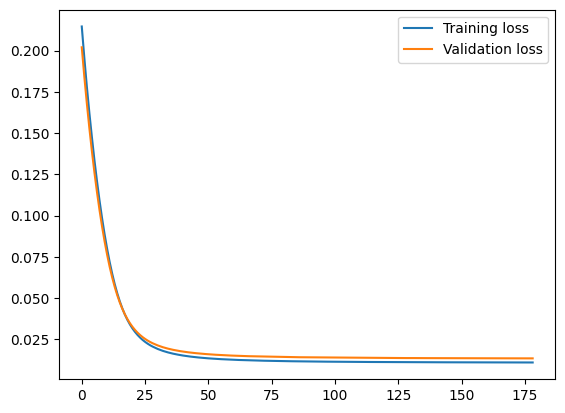

In [29]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

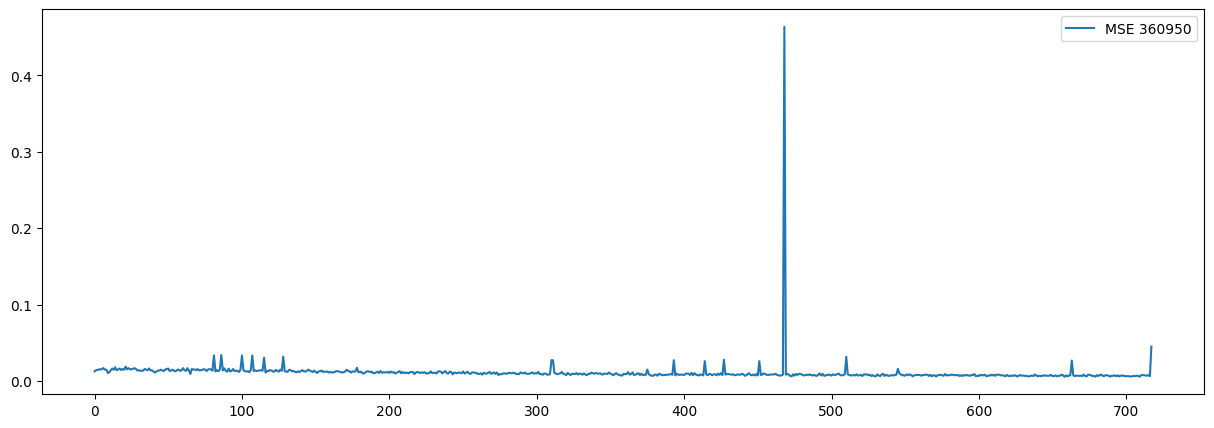

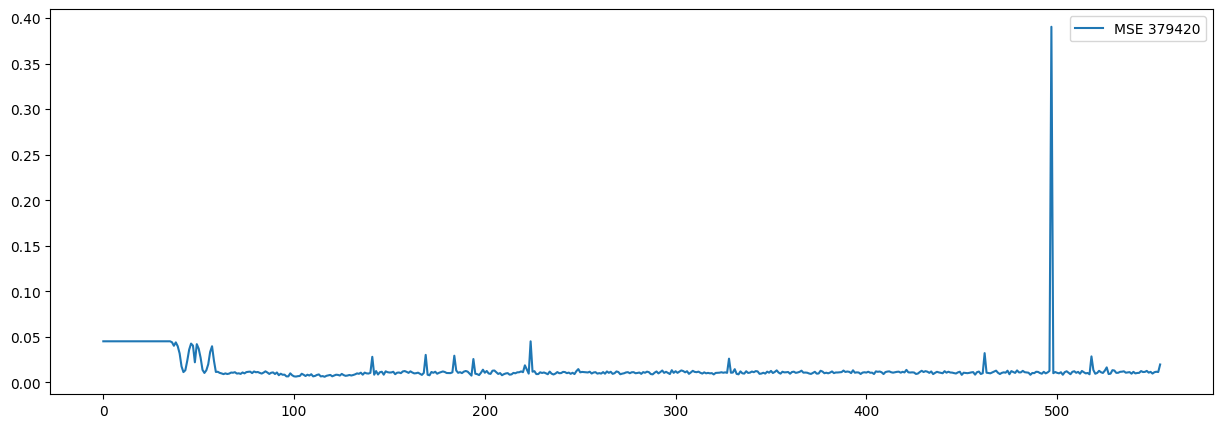

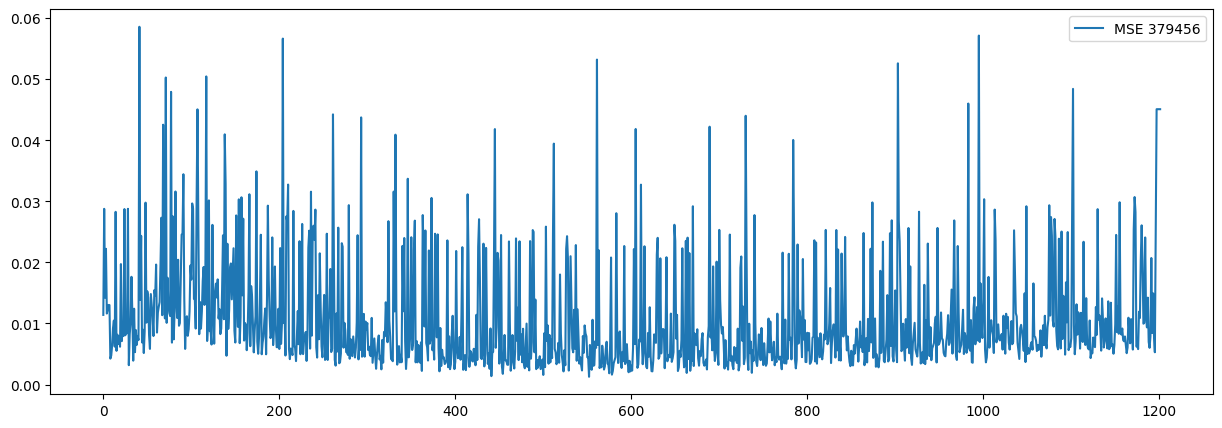

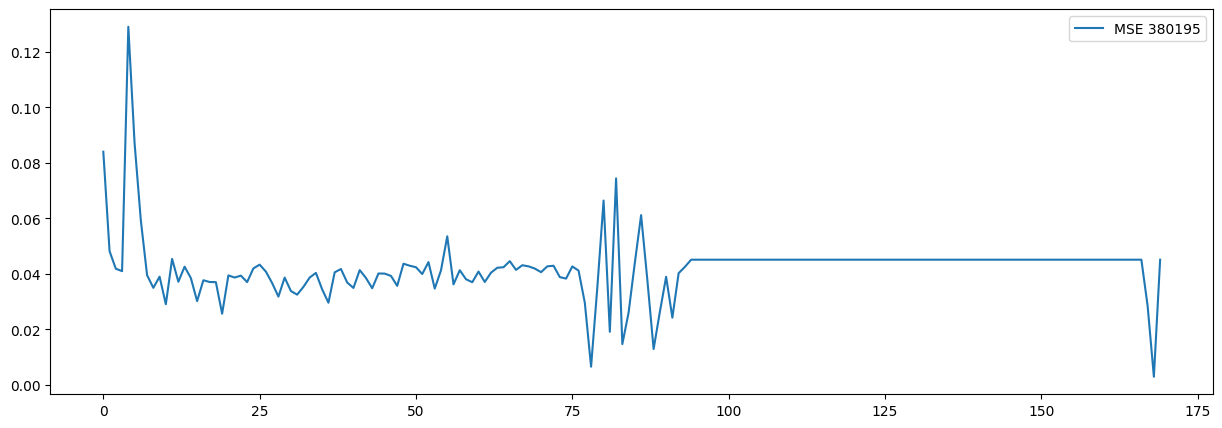

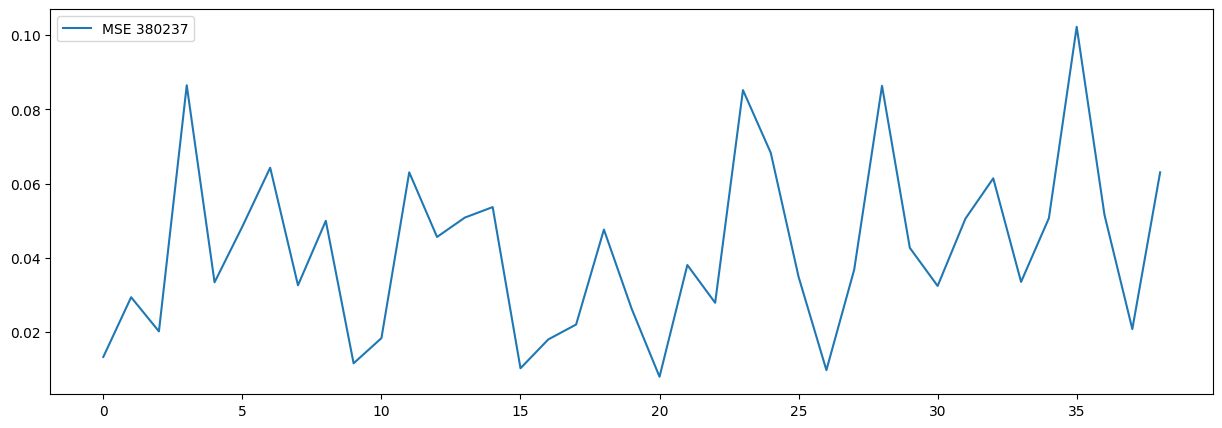

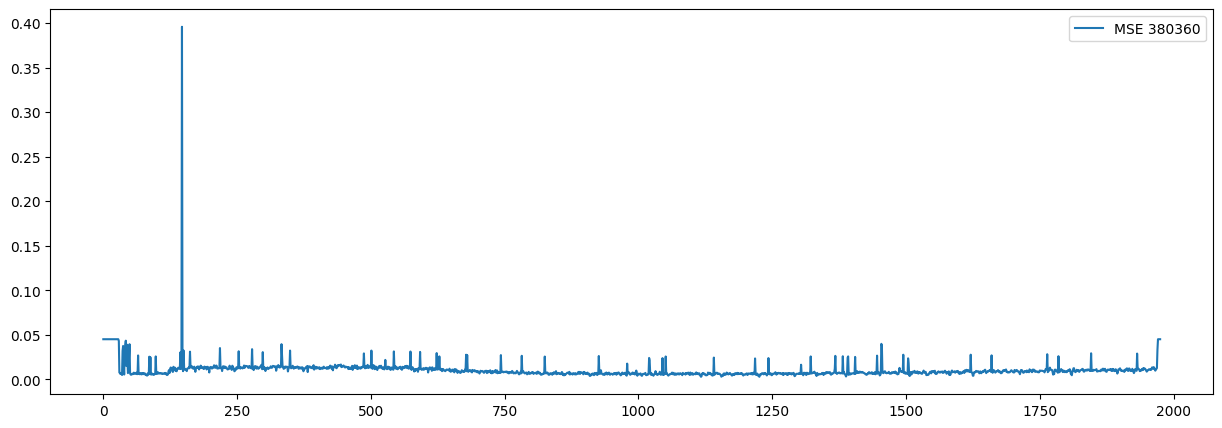

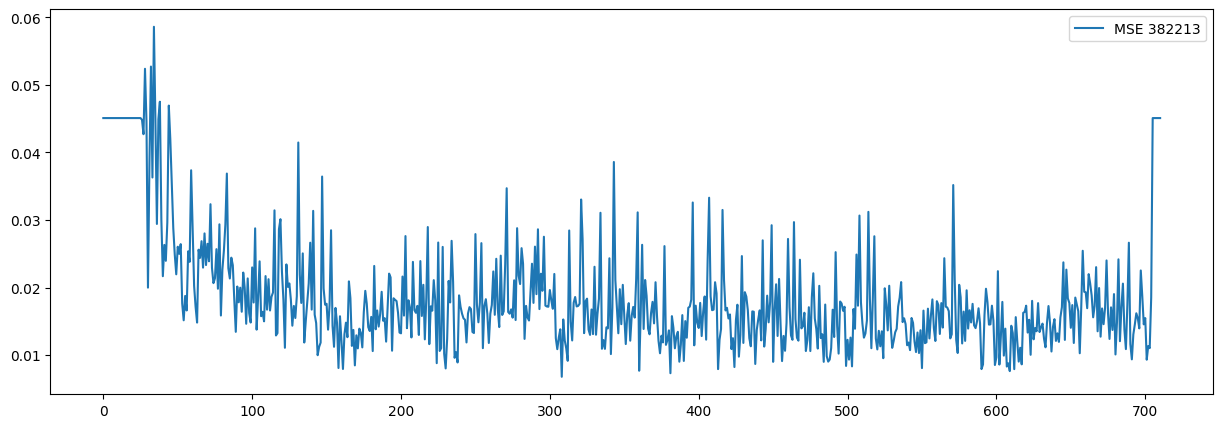

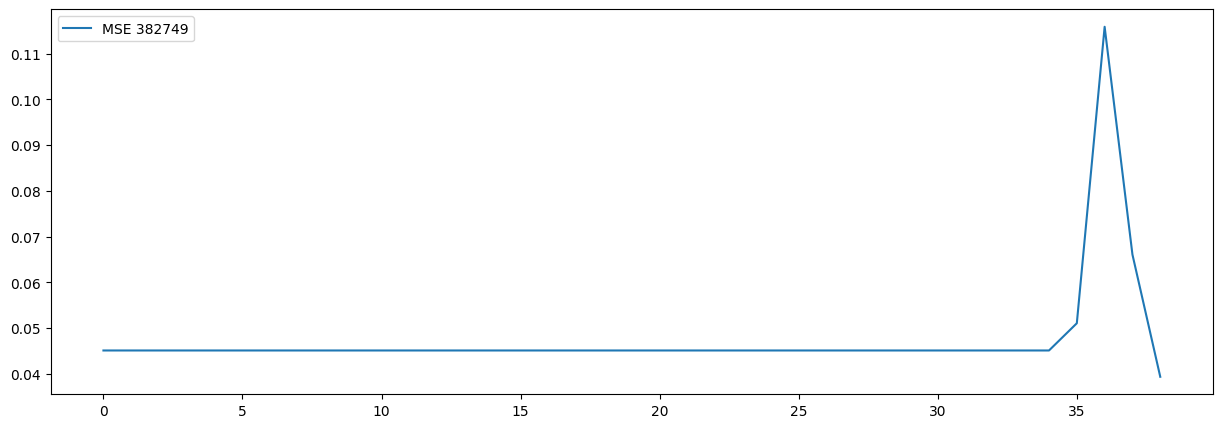

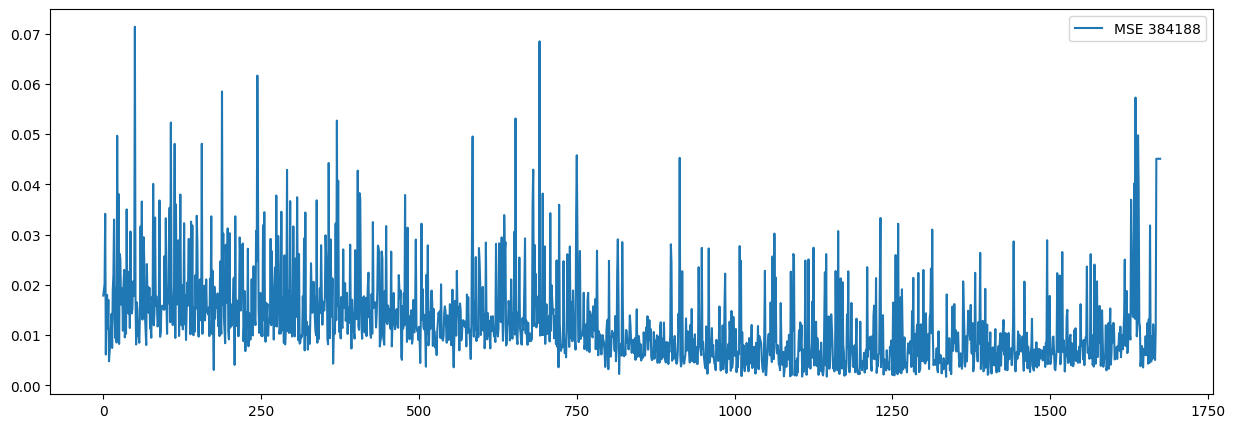

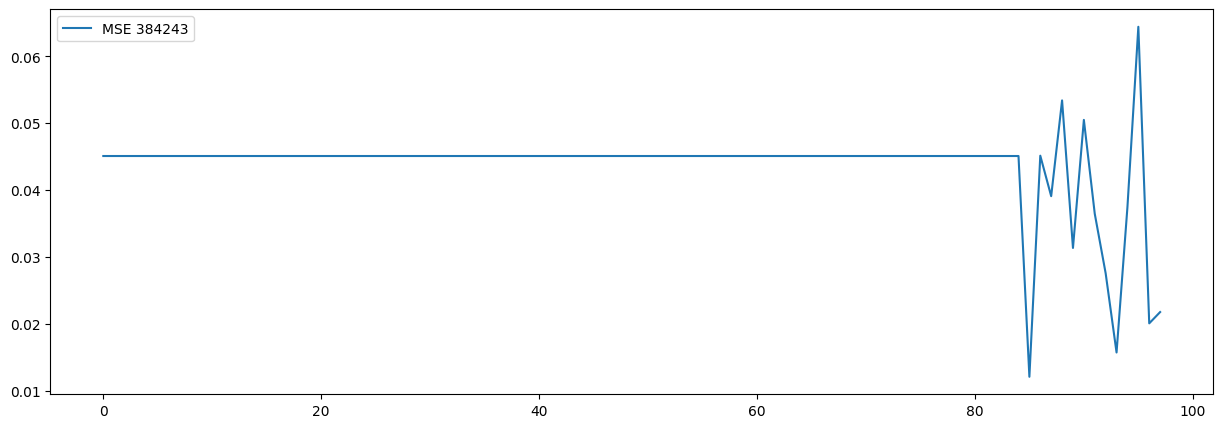

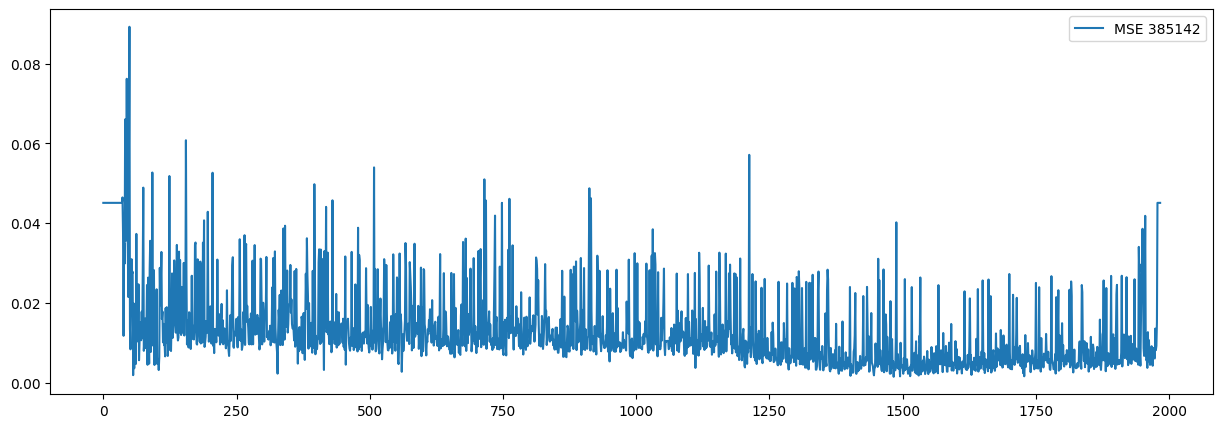

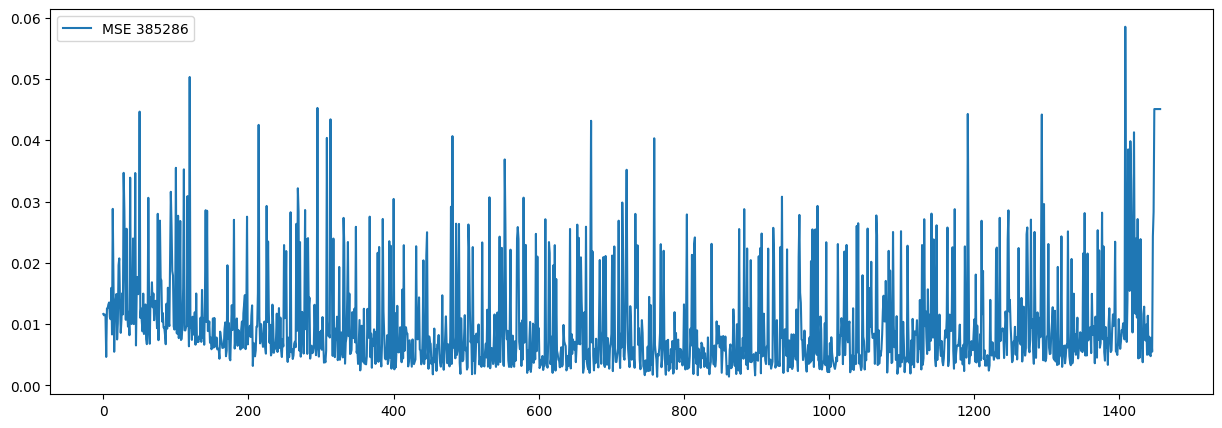

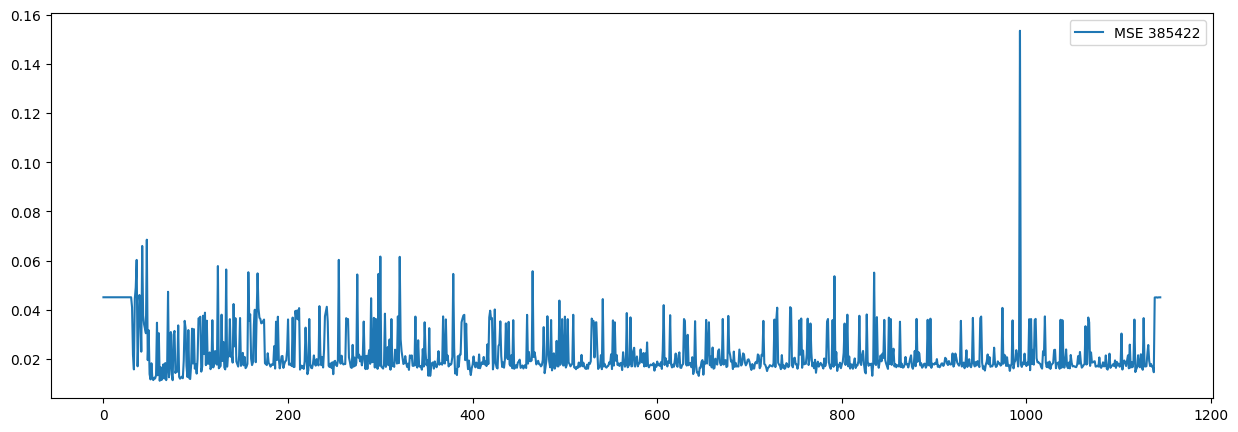

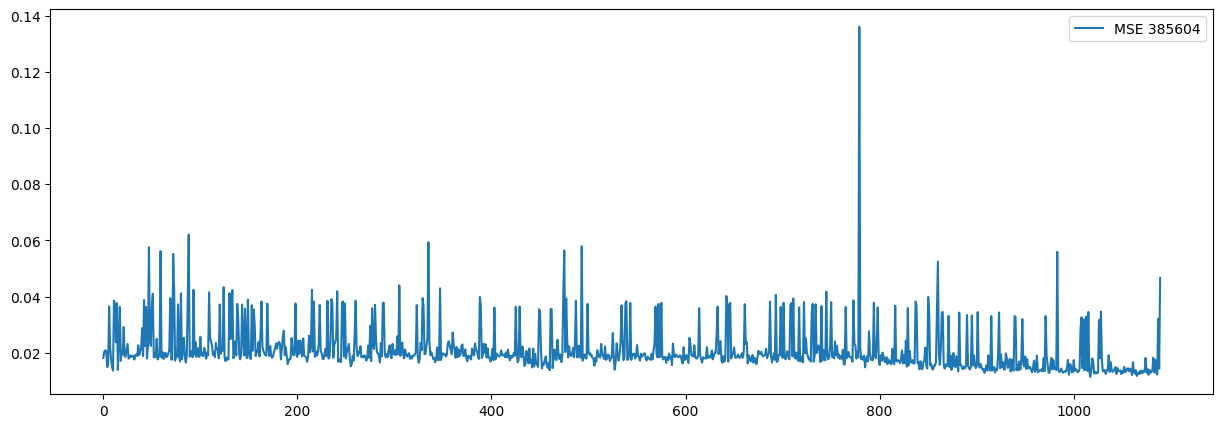

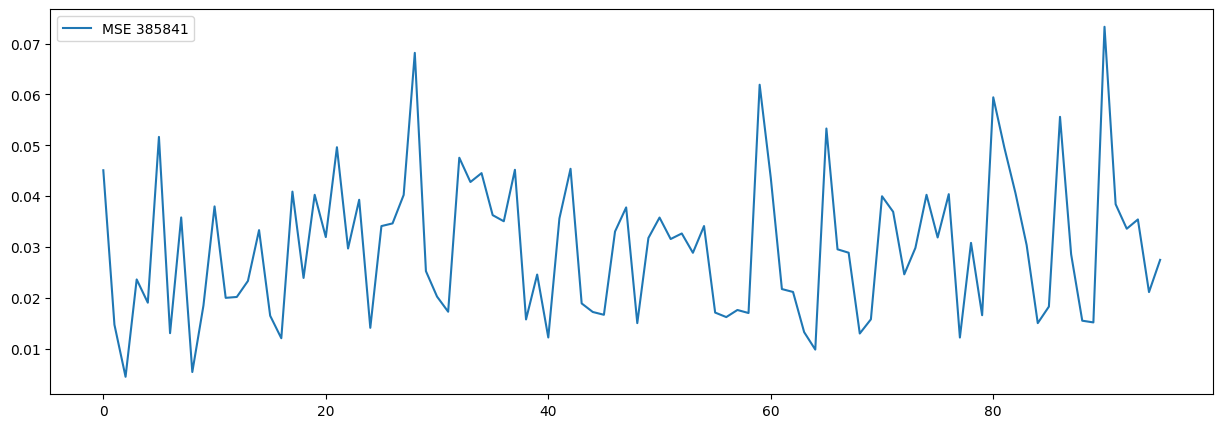

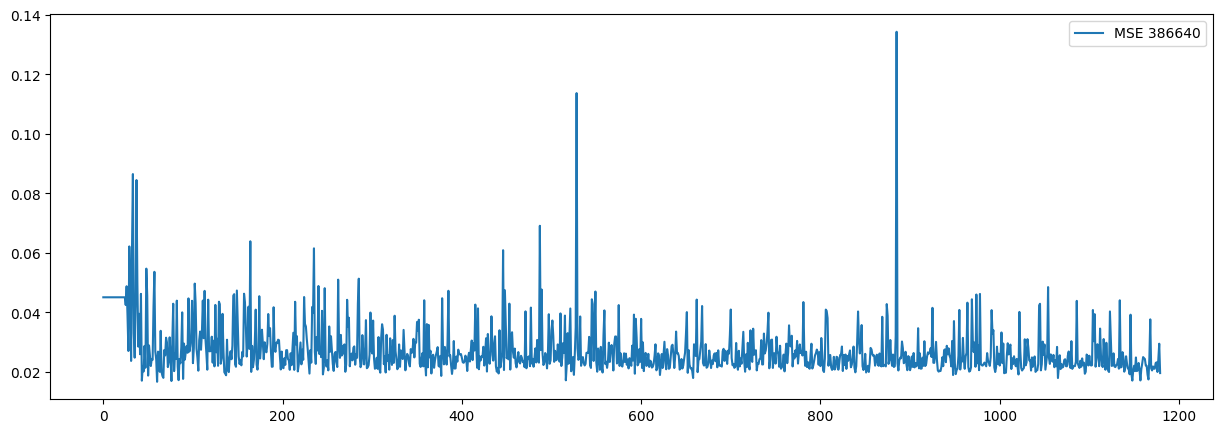

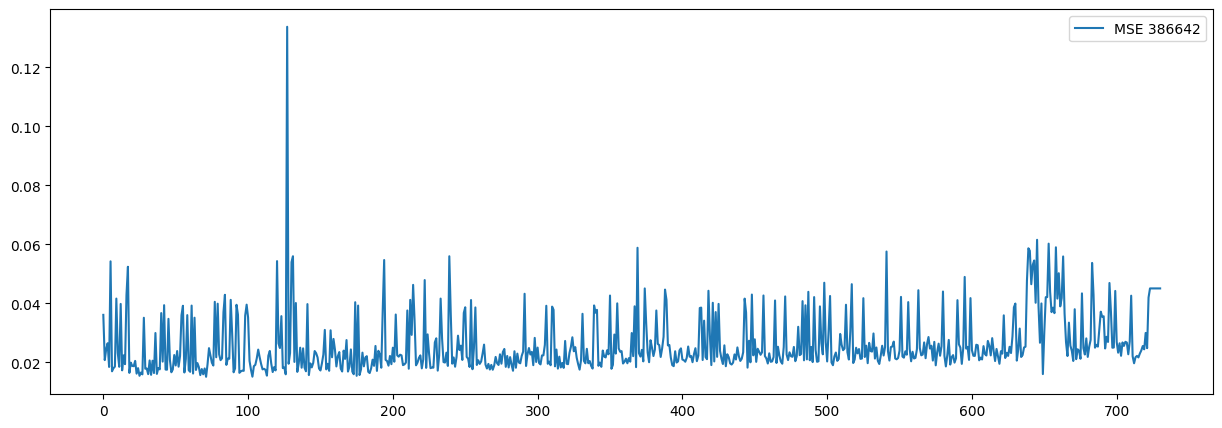

In [30]:
for run_number in np.unique(run_arr):
    test_data = data_arr[run_arr == run_number]
    _, avg_mse = ae.predict_on_batch(test_data)  # This will not batch input data

    plt.figure(figsize=(15, 5))
    plt.plot(range(avg_mse.shape[0]), avg_mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [31]:
os.makedirs("../models/tensorflow", exist_ok=True)

# https://keras.io/api/models/model_saving_apis/export/
# Using SavedModel format through Keras 3 - tf_saved_model
ae.export(
    "../models/tensorflow/1",
    format="tf_saved_model",
    input_signature=[
        tf.TensorSpec((None, 51), tf.float32, name="input_0")
    ],
)

INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets


INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets


Saved artifact at '../models/tensorflow/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 51), dtype=tf.float32, name='input_0')
Output Type:
  Tuple[TensorSpec(shape=(None, 51), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)]
Captures:
  139794085148048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085148624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085148432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085149584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085149008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085150160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085149200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139794085150352: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [39]:
# Inspect input and output signatures
model = tf.saved_model.load("../models/tensorflow/1")
signature = model.signatures["serving_default"]

print("Inputs")
for structure_input_signature in signature.structured_input_signature:
    if isinstance(structure_input_signature, dict):
        for input_name, tensor in structure_input_signature.items():
            print(f"name={input_name} dtype={tensor.dtype} shape={tensor.shape}")

print("\nOutput")
for output_name, tensor in signature.structured_outputs.items():
    print(f"name={output_name} dtype={tensor.dtype} shape={tensor.shape}")

Inputs
name=input_0 dtype=<dtype: 'float32'> shape=(None, 51)

Output
name=output_0 dtype=<dtype: 'float32'> shape=(None, 51)
name=output_1 dtype=<dtype: 'float32'> shape=(None,)


In [33]:
os.makedirs("../models/tensorflow_as_onnx", exist_ok=True)

# https://keras.io/api/models/model_saving_apis/export/
# Using SavedModel format through Keras 3 - onnx
ae.export(
    "../models/tensorflow_as_onnx/model.onnx",
    format="onnx",
    input_signature=[
        tf.TensorSpec((None, 51), tf.float32, name="input_0")
    ],
)

# You can use [netron](https://netron.app/) to inspect the onnx model

Saved artifact at '../models/tensorflow_as_onnx/model.onnx'.


I0000 00:00:1743183209.339265  540253 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1743183209.341289  540253 single_machine.cc:361] Starting new session
I0000 00:00:1743183209.408249  540253 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1743183209.408318  540253 single_machine.cc:361] Starting new session


In [34]:
import onnx
import onnxruntime

# Check model consistency, an exception will be raised if something is wrong
onnx_model = onnx.load("../models/tensorflow_as_onnx/model.onnx")
onnx.checker.check_model(onnx_model)

# Load the inference session and print input and output layers
# which are useful for creating the `config.pbtxt` file
# required by NVIDIA Triton Inference Server
sess = onnxruntime.InferenceSession("../models/tensorflow_as_onnx/model.onnx")
_inputs = sess.get_inputs()
_outputs = sess.get_outputs()

print("inputs")
for _input in _inputs:
    print(_input)

print("\noutputs")
for _output in _outputs:
    print(_output)

# Generate a demo config.pbtxt
configs_inputs = "input [\n"
for idx, _input in enumerate(_inputs):
    shp = ["-1" if "unk" in str(value) else str(value) for value in _input.shape]
    dims = ", ".join(shp) if len(_input.shape) > 1 else "-1"
    configs_inputs += f"  {{\n    name: \"{_input.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_inputs):
        configs_inputs += ","
    configs_inputs += "\n"
configs_inputs += "]"

configs_outputs = "output [\n"
for idx, _output in enumerate(_outputs):
    shp = ["-1" if "unk" in str(value) else str(value) for value in _output.shape]
    dims = ", ".join(shp) if len(_output.shape) > 1 else "-1"
    configs_outputs += f"  {{\n    name: \"{_output.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_outputs):
        configs_outputs += ","
    configs_outputs += "\n"
configs_outputs += "]"

config_content = f"""name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
{configs_inputs}
{configs_outputs}
"""

print()
print(config_content)

inputs
NodeArg(name='input_0', type='tensor(float)', shape=['unk__38', 51])

outputs
NodeArg(name='Identity:0', type='tensor(float)', shape=['unk__39', 51])
NodeArg(name='Identity_1:0', type='tensor(float)', shape=['unk__40'])

name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
input [
  {
    name: "input_0"
    data_type: TYPE_FP32
    dims: [-1, 51]
  }
]
output [
  {
    name: "Identity:0"
    data_type: TYPE_FP32
    dims: [-1, 51]
  },
  {
    name: "Identity_1:0"
    data_type: TYPE_FP32
    dims: [-1]
  }
]



In [35]:
# Since there is not way to specify the output signature of the model
# when exporting it using Keras 3 and updating the output of the model call() 
# to be a dictionary is too cumbersome (since for some reason it makes the training metrics disappear).
# This block of the code update the onnx graph inputs and outputs nodes names.

graph_def = onnx_model.graph
nodes = graph_def.node
outputs = graph_def.output
for idx, graph_output in enumerate(outputs):
    new_output_name = f"output_{idx}"
    for node in nodes:
        if graph_output.name in node.input:
            new_node_inputs = [new_output_name if input == graph_output.name else input for input in node.input]
            del node.input[:]
            node.input.extend(new_node_inputs)
        if graph_output.name in node.output:
            new_node_outputs = [new_output_name if output == graph_output.name else output for output in node.output]
            del node.output[:]
            node.output.extend(new_node_outputs)
    graph_output.name = new_output_name

onnx.checker.check_model(onnx_model)
onnx.save(onnx_model, "../models/tensorflow_as_onnx/model-updated.onnx")

sess = onnxruntime.InferenceSession("../models/tensorflow_as_onnx/model-updated.onnx")
_inputs = sess.get_inputs()
_outputs = sess.get_outputs()

print("inputs")
for _input in _inputs:
    print(_input)

print("\noutputs")
for _output in _outputs:
    print(_output)

# Generate a demo config.pbtxt
configs_inputs = "input [\n"
for idx, _input in enumerate(_inputs):
    shp = ["-1" if "unk" in str(value) else str(value) for value in _input.shape]
    dims = ", ".join(shp) if len(_input.shape) > 1 else "-1"
    configs_inputs += f"  {{\n    name: \"{_input.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_inputs):
        configs_inputs += ","
    configs_inputs += "\n"
configs_inputs += "]"

configs_outputs = "output [\n"
for idx, _output in enumerate(_outputs):
    shp = ["-1" if "unk" in str(value) else str(value) for value in _output.shape]
    dims = ", ".join(shp) if len(_output.shape) > 1 else "-1"
    configs_outputs += f"  {{\n    name: \"{_output.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_outputs):
        configs_outputs += ","
    configs_outputs += "\n"
configs_outputs += "]"

config_content = f"""name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
{configs_inputs}
{configs_outputs}
"""

print()
print(config_content)

inputs
NodeArg(name='input_0', type='tensor(float)', shape=['unk__38', 51])

outputs
NodeArg(name='output_0', type='tensor(float)', shape=['unk__39', 51])
NodeArg(name='output_1', type='tensor(float)', shape=['unk__40'])

name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
input [
  {
    name: "input_0"
    data_type: TYPE_FP32
    dims: [-1, 51]
  }
]
output [
  {
    name: "output_0"
    data_type: TYPE_FP32
    dims: [-1, 51]
  },
  {
    name: "output_1"
    data_type: TYPE_FP32
    dims: [-1]
  }
]

